# lorapy symbol extraction

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np
from six.moves import cPickle
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data')

SYMBOL_DIR = _BASE_DATA_DIR.joinpath('lora-symbols-20k')

# load

## files

In [4]:
symloader = lorapy.load_dotp(SYMBOL_DIR)
symloader.file_list

2020-04-09 07:35:08.691 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/lora-symbols-20k
2020-04-09 07:35:08.699 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 106 data file(s)


[DotPFile(id=0 | name='lora_BW2_SF11_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=1 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW8_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=3 | name='lora_BW1_SF11_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=4 | name='lora_BW8_SF10_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=5 | name='lora_BW7_SF10_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=6 | name='lora_BW7_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=7 | name='lora_BW2_SF11_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=8 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW7_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=10 | name='lora_BW2_SF12_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=11 | name='lora_BW8_SF12_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=12 | name='lora_BW8_SF12_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=13 | name='lora_BW7_SF12_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=14 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=15 | na

In [40]:
symloader.filter(bw=9)

[DotPFile(id=8 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=14 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=15 | name='lora_BW9_SF10_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=17 | name='lora_BW9_SF11_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=32 | name='lora_BW9_SF12_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=36 | name='lora_BW9_SF12_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=40 | name='lora_BW9_SF12_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=42 | name='lora_BW9_SF12_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=48 | name='lora_BW9_SF12_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=53 | name='lora_BW9_SF10_915MHz_20ksps_Att20_v0.p'),
 DotPFile(id=55 | name='lora_BW9_SF12_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=65 | name='lora_BW9_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=70 | name='lora_BW9_SF10_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=80 | name='lora_BW9_SF10_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=84 | name='lora_BW9_SF11_915MHz_20ksps_Att40_v0.p'),
 DotPFile

## symbols

In [41]:
file = symloader.select(89)
file

DotPFile(id=89 | name='lora_BW9_SF11_915MHz_20ksps_Att100_v0.p')

In [42]:
symbol = file.to_signal()
symbol

2020-04-09 07:38:37.041 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 800 and packet length: 24200
2020-04-09 07:38:37.153 | INFO     | lorapy.datafile._base_file:load:61 - loaded 4358400 samples from file


BaselineSymbolSet(num symbols=5448 | BW: 9 | SF: 11 | Att: 100 | samples per symbol: 800 | packet length: 24200)

# visualize

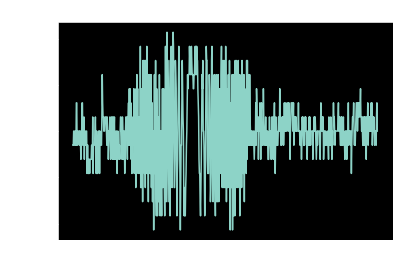

In [84]:
symbol.plot()

In [39]:
symbol.num_symbols

7176